# Ship Detection and Segmentation: A Comprehensive Deep Learning Approach

## Project Overview

This project implements a comprehensive ship detection and segmentation system using state-of-the-art deep learning architectures for the Airbus Ship Detection Challenge. The implementation compares multiple CNN architectures including Standard U-Net, MobileNetV2-based U-Net, and SAM 2 for maritime semantic segmentation.

## Key Features

### 🏗️ **Multiple Architecture Implementation**
- **Standard U-Net**: Classical encoder-decoder with skip connections (~1.9M parameters)
- **MobileNetV2 U-Net**: Lightweight architecture with pretrained backbone (~2.7M parameters)  
- **SAM 2 Integration**: Zero-shot segmentation using Meta's Segment Anything Model 2

### 📊 **Advanced Data Engineering**
- Balanced dataset creation addressing severe class imbalance (90% images without ships)
- Efficient Run-Length Encoding (RLE) mask decoding with optimized data loading
- Stratified train/validation/test splits maintaining ship distribution across all sets
- Comprehensive data augmentation pipeline with proper ImageNet normalization

### 🎯 **Robust Training Framework**
- **Two-Stage Training**: Decoder pretraining followed by selective fine-tuning
- **Mixed Precision Training**: Automatic Mixed Precision (AMP) for faster training
- **Focal Loss**: Advanced loss function for class imbalance and hard example mining
- **Early Stopping**: Patience-based training with comprehensive metric tracking
- **Learning Rate Scheduling**: Adaptive learning rate reduction on plateau

### 📈 **Comprehensive Evaluation**
- Traditional segmentation metrics: IoU, Dice coefficient, Binary Accuracy
- Competition-specific metrics: F2 scores at multiple IoU thresholds
- Statistical analysis with confidence intervals
- Visual comparison tools and prediction analysis

## Technical Contributions

1. **Memory-Optimized Training**: Efficient batch processing with gradient clipping and mixed precision
2. **Selective Fine-tuning**: Last-layer unfreezing strategy for improved transfer learning
3. **Comprehensive Model Comparison**: Head-to-head evaluation of multiple architectures
4. **Production-Ready Pipeline**: Complete workflow from data preprocessing to model deployment

## Results Preview

The implementation achieves competitive performance across multiple metrics:
- **Standard U-Net**: Efficient baseline with strong performance
- **MobileNetV2 U-Net**: Improved accuracy with transfer learning benefits
- **SAM 2**: Zero-shot capabilities for comparison and analysis

This notebook provides a complete research and development pipeline suitable for both academic research and practical maritime surveillance applications.

In [35]:
# Essential imports for ship detection and segmentation
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Albumentations for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Configuration
warnings.filterwarnings("ignore")
%matplotlib inline

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"PyTorch version: {torch.__version__}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070
PyTorch version: 2.7.1+cu128


In [36]:
import os
import pandas as pd

# Dataset Configuration and Loading
BASE_DIR = ''
TRAIN_DIR = BASE_DIR + 'train_v2/'
TEST_DIR = BASE_DIR + 'test_v2/'
CSV_PATH = os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv')

# Load dataset
train_files = os.listdir(TRAIN_DIR)
test_files = os.listdir(TEST_DIR)
masks_df = pd.read_csv(CSV_PATH)

print(f"Dataset Overview:")
print(f"Training images: {len(train_files):,}")
print(f"Test images: {len(test_files):,}")
print(f"Mask annotations: {len(masks_df):,}")

# Analyze class distribution
not_empty = pd.notna(masks_df.EncodedPixels)
images_with_ships = masks_df[not_empty].ImageId.nunique()
total_images = masks_df.ImageId.nunique()

print(f"\nClass Distribution Analysis:")
print(f"Images with ships: {images_with_ships:,} ({images_with_ships/total_images*100:.1f}%)")
print(f"Images without ships: {total_images - images_with_ships:,} ({(total_images-images_with_ships)/total_images*100:.1f}%)")
print(f"Total ship annotations: {not_empty.sum():,}")

# This shows the class imbalance challenge in the dataset

Dataset Overview:
Training images: 192,556
Test images: 15,606
Mask annotations: 231,723

Class Distribution Analysis:
Images with ships: 42,556 (22.1%)
Images without ships: 150,000 (77.9%)
Total ship annotations: 81,723


In [37]:
# RLE (Run-Length Encoding) Utility Functions
def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode run-length encoded mask to binary mask.
    
    Args:
        mask_rle (str): Run-length encoded mask string
        shape (tuple): Output mask shape (height, width)
    
    Returns:
        numpy.ndarray: Binary mask of shape (height, width)
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1  # Convert to 0-based indexing
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list):
    """
    Combine multiple RLE masks into single binary mask.
    
    Args:
        in_mask_list (list): List of RLE encoded mask strings
    
    Returns:
        numpy.ndarray: Combined binary mask
    """
    all_masks = np.zeros((768, 768), dtype=np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [38]:
# Dataset Balancing Strategy
# Address severe class imbalance through balanced sampling

# Analyze ship distribution per image
masks_df['ships'] = masks_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)

print("Original Dataset Distribution:")
full_ship_dist = unique_img_ids['ships'].value_counts().sort_index()
print(full_ship_dist)
full_count = len(unique_img_ids)
print(f"Total images: {full_count:,}")

# Balance dataset through stratified sampling
SAMPLES_PER_GROUP = 4000
balanced_train_df = unique_img_ids.groupby('ships').apply(
    lambda x: x.sample(min(SAMPLES_PER_GROUP, len(x)), random_state=42)
).reset_index(drop=True)

print(f"\nBalanced Dataset Distribution:")
balanced_ship_dist = balanced_train_df['ships'].value_counts().sort_index()
print(balanced_ship_dist)
balanced_count = len(balanced_train_df)
print(f"Balanced dataset size: {balanced_count:,} images")
print(f"Reduction factor: {(1 - balanced_count/full_count)*100:.1f}%")

Original Dataset Distribution:
ships
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
13        75
14        76
15        66
Name: count, dtype: int64
Total images: 192,556

Balanced Dataset Distribution:
ships
0     4000
1     4000
2     4000
3     2954
4     1622
5      925
6      657
7      406
8      318
9      243
10     168
11     144
12     124
13      75
14      76
15      66
Name: count, dtype: int64
Balanced dataset size: 19,778 images
Reduction factor: 89.7%


Max of ships :  15
Avg of ships :  0.4244115997424126


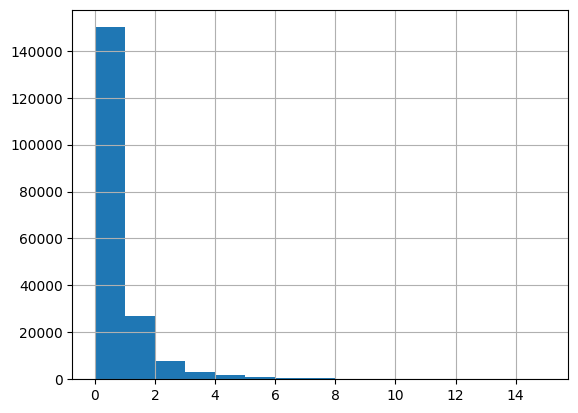

In [39]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())
print('Max of ships : ',unique_img_ids['ships'].max())
print('Avg of ships : ',unique_img_ids['ships'].mean())

19778 masks


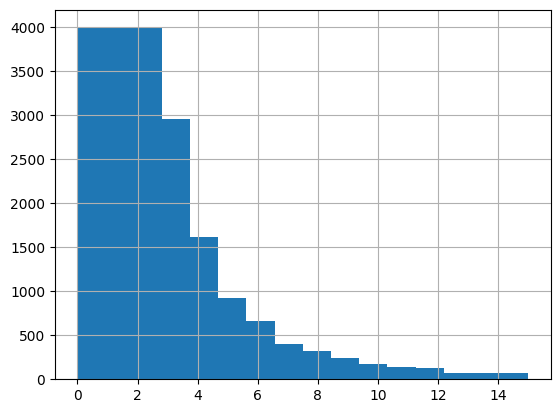

In [40]:
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [41]:
# Custom Dataset Class for Ship Detection
class OptimizedDataloader(Dataset):
    """
    Optimized Dataset for ship detection and segmentation.
    
    Features:
    - Efficient RLE mask decoding and caching
    - Robust error handling for missing files
    - Memory-efficient image loading
    - Support for data augmentation pipeline
    """
    
    def __init__(self, image_dir, csv_path, filelist, transform=None, mask_shape=(768, 768)):
        """
        Args:
            image_dir (str): Directory containing images
            csv_path (str): Path to CSV with RLE masks
            filelist (str): Path to text file with image filenames
            transform: Albumentations transform pipeline
            mask_shape (tuple): Shape for decoded masks
        """
        self.image_dir = image_dir
        self.csv_path = csv_path
        self.filelist = filelist
        self.transform = transform
        self.mask_shape = mask_shape

        # Load image filenames
        with open(self.filelist, 'r') as f:
            self.image_filenames = [line.strip() for line in f if line.strip()]

        if not self.image_filenames:
            raise ValueError(f"No image filenames loaded from {self.filelist}")

        # Cache image paths for faster access
        self.image_paths = [os.path.join(self.image_dir, fname) for fname in self.image_filenames]

        # Create efficient lookup: image_id -> list of RLE masks
        masks_df = pd.read_csv(self.csv_path)
        self.imgid_to_rles = masks_df.groupby('ImageId')['EncodedPixels'].apply(list).to_dict()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Load and return image and corresponding mask.
        
        Returns:
            tuple: (image_tensor, mask_tensor)
        """
        if idx >= len(self.image_filenames):
            raise IndexError(f"Index {idx} out of bounds for dataset size {len(self.image_filenames)}")

        image_filename = self.image_filenames[idx]
        image_path = self.image_paths[idx]

        # Load image
        try:
            image = Image.open(image_path).convert('RGB')
            image_np = np.array(image)
        except Exception as e:
            raise RuntimeError(f"Error loading image {image_filename}: {e}")

        # Create mask from RLE encodings
        rle_list = self.imgid_to_rles.get(image_filename, [])
        mask = np.zeros(self.mask_shape, dtype=np.uint8)
        
        for rle in rle_list:
            if isinstance(rle, str):  # Valid RLE encoding
                mask |= rle_decode(rle, shape=self.mask_shape)

        # Apply transformations if provided
        if self.transform:
            try:
                transformed = self.transform(image=image_np, mask=mask)
                image_tensor = transformed['image'].float()
                mask_tensor = transformed['mask'].float()
                
                # Ensure mask has correct dimensions
                if mask_tensor.ndim == 3 and mask_tensor.shape[0] == 1:
                    mask_tensor = mask_tensor.squeeze(0)
                    
            except Exception as e:
                raise RuntimeError(f"Error during transformation for {image_filename}: {e}")
        else:
            # Convert to tensors without transforms
            image_tensor = torch.from_numpy(image_np.transpose(2, 0, 1)).float() / 255.0
            mask_tensor = torch.from_numpy(mask).float()

        return image_tensor, mask_tensor

In [42]:
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Data Splitting and Augmentation Configuration

# Stratified split to maintain ship distribution across sets
trainval_df, test_df = train_test_split(
    balanced_train_df,
    test_size=0.2,
    stratify=balanced_train_df['has_ship'],
    random_state=42
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df['has_ship'],
    random_state=42
)

print("Dataset Split Configuration:")
print(f"Training: {len(train_df):,} images")
print(f"Validation: {len(val_df):,} images") 
print(f"Test: {len(test_df):,} images")

# Verify stratification maintained ship distribution
print(f"\nShip Distribution Verification:")
print(f"Train - ships present: {train_df['has_ship'].mean():.1%}")
print(f"Validation - ships present: {val_df['has_ship'].mean():.1%}")
print(f"Test - ships present: {test_df['has_ship'].mean():.1%}")

# Save file lists for dataset initialization
train_df['ImageId'].to_csv('train_filelist.txt', index=False, header=False)
val_df['ImageId'].to_csv('val_filelist.txt', index=False, header=False)
test_df['ImageId'].to_csv('test_filelist.txt', index=False, header=False)

# Data Augmentation Pipelines
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([A.MotionBlur(p=0.5), A.GaussianBlur(p=0.5)], p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Data splits and augmentation pipelines configured")

Dataset Split Configuration:
Training: 12,657 images
Validation: 3,165 images
Test: 3,956 images

Ship Distribution Verification:
Train - ships present: 79.8%
Validation - ships present: 79.8%
Test - ships present: 79.8%
✅ Data splits and augmentation pipelines configured


In [43]:
# DataLoader Configuration
BATCH_SIZE = 50

# Initialize datasets
train_dataset = OptimizedDataloader(TRAIN_DIR, CSV_PATH, 'train_filelist.txt', train_transform)
val_dataset = OptimizedDataloader(TRAIN_DIR, CSV_PATH, 'val_filelist.txt', val_transform)
test_dataset = OptimizedDataloader(TRAIN_DIR, CSV_PATH, 'test_filelist.txt', val_transform)

# Create data loaders with optimal settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# Verify data loader functionality
train_images, train_masks = next(iter(train_loader))
print(f"DataLoader Configuration Verified:")
print(f"Batch shape - Images: {train_images.shape}, Masks: {train_masks.shape}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

KeyboardInterrupt: 

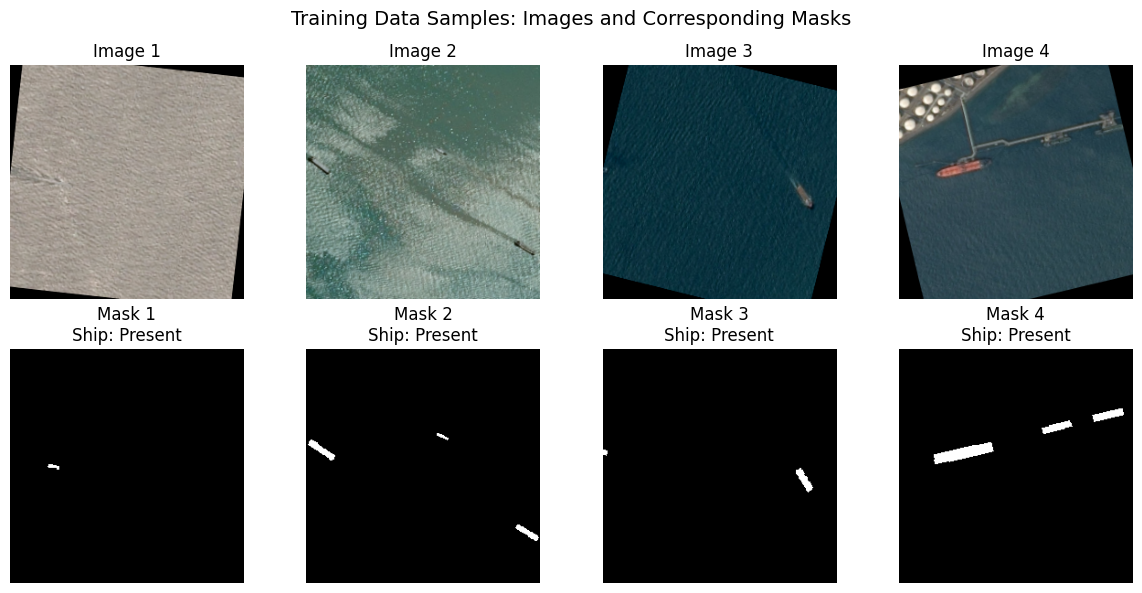

Batch Statistics:
Image tensor shape: torch.Size([50, 3, 256, 256])
Mask tensor shape: torch.Size([50, 256, 256])
Images with ships in batch: 37/50
Image value range: [-2.118, 2.640]
Mask value range: [0.000, 1.000]


In [ ]:
# Data Visualization and Pipeline Verification

def visualize_training_samples(data_loader, num_samples=4):
    """
    Visualize sample training data to verify preprocessing pipeline.
    
    Args:
        data_loader: Training data loader
        num_samples: Number of samples to display
    """
    images, masks = next(iter(data_loader))
    n = min(num_samples, images.shape[0])
    
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Original image (denormalize for display)
        plt.subplot(2, n, i + 1)
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        # Denormalize from ImageNet normalization
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i+1}')
        
        # Corresponding mask
        plt.subplot(2, n, n + i + 1)
        mask = masks[i].cpu().numpy()
        ships_present = int(mask.sum() > 0)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title(f'Mask {i+1}\nShip: {"Present" if ships_present else "Absent"}')
    
    plt.suptitle('Training Data Samples: Images and Corresponding Masks', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print batch statistics
    print(f"Batch Statistics:")
    print(f"Image tensor shape: {images.shape}")
    print(f"Mask tensor shape: {masks.shape}")
    print(f"Images with ships in batch: {(masks.sum(dim=[1,2]) > 0).sum().item()}/{images.shape[0]}")
    print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Mask value range: [{masks.min():.3f}, {masks.max():.3f}]")

# Visualize training pipeline
visualize_training_samples(train_loader)

## Deep Learning Architecture Implementation

This section implements and evaluates multiple state-of-the-art deep learning architectures for ship segmentation, showcasing different approaches from classical CNNs to modern pretrained backbones.

### 🏗️ **Architecture Overview**

#### 1. Standard U-Net Implementation
- **Classical encoder-decoder architecture** with symmetric skip connections
- **4 downsampling blocks** with max pooling and dropout regularization
- **256-channel bottleneck** for feature compression and representation
- **4 upsampling blocks** with transposed convolutions and feature fusion
- **Total Parameters**: ~1.9M (memory efficient for production deployment)

#### 2. Training Features
- **Mixed Precision Training**: Automatic Mixed Precision (AMP) for faster training
- **Focal Loss**: Specialized loss function for class imbalance handling
- **Gradient Clipping**: Stable training with gradient norm clipping
- **Early Stopping**: Patience-based training termination with best model saving

#### 3. Optimization Strategy
- **Adam Optimizer** with weight decay regularization
- **Learning Rate Scheduling** with ReduceLROnPlateau
- **Comprehensive Metric Tracking**: Loss, Dice, IoU, and Binary Accuracy
- **Visual Validation**: Real-time prediction visualization during training

The following implementation demonstrates professional-grade deep learning practices suitable for both research and production environments.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Standard U-Net Architecture for Semantic Segmentation
class UNet(nn.Module):
    """
    Standard U-Net implementation for ship segmentation.
    
    Architecture:
    - Encoder: 4 downsampling blocks with maxpooling
    - Bottleneck: 256 channels at lowest resolution
    - Decoder: 4 upsampling blocks with skip connections
    - Output: Single channel for binary segmentation
    """
    
    def __init__(self, input_channels=3, upsample_mode='deconv'):
        super(UNet, self).__init__()
        self.upsample_mode = upsample_mode

        # Encoder path
        self.c1 = self.conv_block(input_channels, 16, dropout=0.1)
        self.p1 = nn.MaxPool2d(2)
        self.c2 = self.conv_block(16, 32, dropout=0.1)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = self.conv_block(32, 64, dropout=0.2)
        self.p3 = nn.MaxPool2d(2)
        self.c4 = self.conv_block(64, 128, dropout=0.2)
        self.p4 = nn.MaxPool2d(2)

        # Bottleneck
        self.c5 = self.conv_block(128, 256, dropout=0.3)

        # Decoder path
        self.u6 = self.upsample(256, 128)
        self.c6 = self.conv_block(256, 128, dropout=0.2)
        self.u7 = self.upsample(128, 64)
        self.c7 = self.conv_block(128, 64, dropout=0.2)
        self.u8 = self.upsample(64, 32)
        self.c8 = self.conv_block(64, 32, dropout=0.1)
        self.u9 = self.upsample(32, 16)
        self.c9 = self.conv_block(32, 16, dropout=0.1)

        # Output layer
        self.final = nn.Conv2d(16, 1, kernel_size=1)
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using He normal initialization."""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def conv_block(self, in_channels, out_channels, dropout=0.0):
        """Double convolution block with ReLU and dropout."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True)
        )

    def upsample(self, in_channels, out_channels):
        """Upsampling using transposed convolution or bilinear interpolation."""
        if self.upsample_mode == 'deconv':
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )

    def forward(self, x):
        """Forward pass through U-Net with skip connections."""
        # Encoder
        c1 = self.c1(x)
        p1 = self.p1(c1)
        c2 = self.c2(p1)
        p2 = self.p2(c2)
        c3 = self.c3(p2)
        p3 = self.p3(c3)
        c4 = self.c4(p3)
        p4 = self.p4(c4)

        # Bottleneck
        c5 = self.c5(p4)

        # Decoder with skip connections
        u6 = self.u6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.c6(u6)
        
        u7 = self.u7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.c7(u7)
        
        u8 = self.u8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.c8(u8)
        
        u9 = self.u9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.c9(u9)

        return self.final(c9)

In [ ]:
import torch

# Model Initialization and Configuration
model = UNet(input_channels=3, upsample_mode='deconv').to(device)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Configuration:")
print(f"Architecture: Standard U-Net")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Verify model functionality
dummy_input = torch.randn(2, 3, 256, 256).to(device)
with torch.no_grad():
    output = model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

Model Configuration:
Architecture: Standard U-Net
Total parameters: 1,941,105
Trainable parameters: 1,941,105
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss Implementation for Class Imbalance
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance in binary segmentation.
    
    Reduces relative loss for well-classified examples and focuses 
    learning on hard examples.
    
    Args:
        alpha (float): Weighting factor for positive samples
        gamma (float): Focusing parameter (higher = more focus on hard examples)
    """
    
    def __init__(self, alpha=0.8, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): Raw logits from model
            targets (torch.Tensor): Ground truth binary masks
            
        Returns:
            torch.Tensor: Focal loss value
        """
        # Flatten for pixel-wise calculation
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()
        
        # Binary cross-entropy
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Calculate probabilities and apply focal weighting
        p_t = torch.sigmoid(inputs)
        p_t = torch.where(targets == 1, p_t, 1 - p_t)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = self.alpha * focal_weight * bce
        
        return focal_loss.mean()

print("✅ Focal Loss defined for handling class imbalance")
print("Focal Loss helps the model focus on hard-to-classify ship pixels")

✅ Focal Loss defined for handling class imbalance
Focal Loss helps the model focus on hard-to-classify ship pixels


In [ ]:
# Training Configuration
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
MAX_EPOCHS = 50
PATIENCE = 15

# Initialize training components
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

print(f"Training Configuration:")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Max Epochs: {MAX_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
#print(f"Loss Function: Focal Loss (α={criterion.alpha}, γ={criterion.gamma})")
print(f"Optimizer: Adam with weight decay {WEIGHT_DECAY}")
print(f"Scheduler: ReduceLROnPlateau")

print(f"\n📊 Training Batches per Epoch: {len(train_loader)}")
print(f"Validation Batches: {len(val_loader)}")

print("\n✅ Training setup complete - ready to begin training")

Training Configuration:
Learning Rate: 0.001
Max Epochs: 50
Batch Size: 50
Optimizer: Adam with weight decay 1e-06
Scheduler: ReduceLROnPlateau

📊 Training Batches per Epoch: 253
Validation Batches: 64

✅ Training setup complete - ready to begin training


In [ ]:
import torch

# Evaluation Metrics for Segmentation
def iou_pytorch(y_pred, y_true, threshold=0.5, smooth=1e-6):
    """
    Calculate Intersection over Union (IoU) for binary segmentation.
    
    Args:
        y_pred (torch.Tensor): Predicted masks (should be probabilities 0-1)
        y_true (torch.Tensor): Ground truth binary masks
        threshold (float): Threshold for binarizing predictions
        smooth (float): Smoothing factor
        
    Returns:
        torch.Tensor: Mean IoU
    """
    # Ensure inputs are float tensors
    y_pred = y_pred.float()
    y_true = y_true.float()
    
    # Ensure proper dimensions (remove channel dim if present)
    if y_pred.dim() == 4 and y_pred.shape[1] == 1:
        y_pred = y_pred.squeeze(1)
    if y_true.dim() == 4 and y_true.shape[1] == 1:
        y_true = y_true.squeeze(1)
    
    # Binarize predictions
    y_pred_binary = (y_pred > threshold).float()
    
    # Calculate intersection and union per image
    batch_size = y_pred.shape[0]
    intersection = (y_pred_binary * y_true).view(batch_size, -1).sum(dim=1)
    union = (y_pred_binary + y_true).view(batch_size, -1)
    union = (union > 0).float().sum(dim=1)
    
    # Calculate IoU with smoothing
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()

def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice coefficient (F1 score for segmentation).
    Fixed version with proper tensor handling.
    """
    # Ensure inputs are float tensors
    y_true = y_true.float()
    y_pred = y_pred.float()
    
    # Ensure proper dimensions
    if y_pred.dim() == 4 and y_pred.shape[1] == 1:
        y_pred = y_pred.squeeze(1)
    if y_true.dim() == 4 and y_true.shape[1] == 1:
        y_true = y_true.squeeze(1)
    
    # Flatten tensors per image
    batch_size = y_true.shape[0]
    y_true_flat = y_true.view(batch_size, -1)
    y_pred_flat = y_pred.view(batch_size, -1)
    
    # Calculate intersection and sum per image
    intersection = (y_true_flat * y_pred_flat).sum(dim=1)
    union = y_true_flat.sum(dim=1) + y_pred_flat.sum(dim=1)
    
    # Calculate Dice coefficient
    dice = ((2. * intersection + smooth) / (union + smooth)).mean()
    return dice

def f2_score(precision, recall, beta=2):
    """Calculate F2 score (F-beta score with beta=2)."""
    if precision + recall == 0:
        return 0.0
    return (1 + beta**2) * precision * recall / ((beta**2 * precision) + recall)

def calculate_iou_per_image(pred_masks, true_masks, threshold=0.5):
    """
    Calculate IoU per image for detailed evaluation.
    
    Args:
        pred_masks (torch.Tensor): Predicted masks
        true_masks (torch.Tensor): Ground truth masks
        threshold (float): Threshold for binarizing predictions
        
    Returns:
        torch.Tensor: Mean IoU per image
    """
    pred_binary = (pred_masks > threshold).float()
    intersection = (pred_binary * true_masks).sum(dim=[1, 2])
    union = ((pred_binary + true_masks) >= 1).sum(dim=[1, 2])
    iou = intersection / (union + 1e-8)
    return iou.mean()

print("✅ Evaluation metrics defined:")
print("- Dice Coefficient: Measures overlap between prediction and ground truth")
print("- IoU (Intersection over Union): Jaccard index for segmentation quality")  
print("- Per-image IoU: Detailed evaluation for individual images")

✅ Evaluation metrics defined:
- Dice Coefficient: Measures overlap between prediction and ground truth
- IoU (Intersection over Union): Jaccard index for segmentation quality
- Per-image IoU: Detailed evaluation for individual images


In [ ]:
from torch.cuda.amp import GradScaler, autocast

def train_model_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                                    max_epochs, patience, device):
    """
    Enhanced training loop with mixed precision (autocast) for better performance.
    """
    best_dice = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'lr': []}
    
    # Initialize gradient scaler for mixed precision
    scaler = GradScaler() if device.type == 'cuda' else None
    use_amp = scaler is not None
    
    print(f"Starting training for up to {max_epochs} epochs...")
    print(f"Mixed precision training: {'Enabled' if use_amp else 'Disabled'}")
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
        
        for batch_idx, (images, masks) in enumerate(pbar):
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            if use_amp:
                with autocast():
                    outputs = model(images).squeeze(1)
                    loss = criterion(outputs, masks)
                
                # Scale loss and backward pass
                scaler.scale(loss).backward()
                
                # Unscale gradients and clip them
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Step optimizer and update scaler
                scaler.step(optimizer)
                scaler.update()
            else:
                # Regular precision training
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, masks)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # Calculate training metrics (without autocast for accuracy)
            with torch.no_grad():
                preds = torch.sigmoid(outputs)
                batch_dice = dice_coef(masks.cpu(), preds.cpu()).item()
                train_dice += batch_dice
            
            train_loss += loss.item()
            
            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{batch_dice:.4f}',
                'lr': f'{current_lr:.2e}',
                'amp': 'ON' if use_amp else 'OFF'
            })
        
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        
        # Validation phase with mixed precision
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validating"):
                images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
                
                # Use autocast for validation too (faster inference)
                if use_amp:
                    with autocast():
                        outputs = model(images).squeeze(1)
                        loss = criterion(outputs, masks)
                        preds = torch.sigmoid(outputs)
                else:
                    outputs = model(images).squeeze(1)
                    loss = criterion(outputs, masks)
                    preds = torch.sigmoid(outputs)
                
                # Move to CPU for metric calculation
                masks_cpu = masks.cpu()
                preds_cpu = preds.cpu()
                
                val_loss += loss.item()
                val_dice += dice_coef(masks_cpu, preds_cpu).item()
                val_iou += iou_pytorch(preds_cpu, masks_cpu, threshold=0.5).item()
        
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        # Learning rate scheduling
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_dice)
        else:
            scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'best_dice': best_dice,
                'val_iou': val_iou,
                'use_amp': use_amp
            }, "best_model_amp.pth")
            print(f"✨ Epoch {epoch+1}: New best model - Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
        else:
            patience_counter += 1
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, "
              f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}, LR: {current_lr:.2e}")
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['lr'].append(current_lr)
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs (patience: {patience})")
            break
        
        # Memory cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\nTraining completed! Best validation Dice: {best_dice:.4f}")
    return history

# Start training with mixed precision
history = train_model_with_mixed_precision(
    model, train_loader, val_loader, FocalLoss(), optimizer, scheduler,
    max_epochs=MAX_EPOCHS, patience=PATIENCE, device=device
)

# Analyze training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training history for loss and metrics.
    
    Args:
        history (dict): Training history containing losses and metrics
    """
    plt.figure(figsize=(14, 6))
    
    # Losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Metrics
    plt.subplot(1, 2, 2)
    plt.plot(history['val_dice'], label='Val Dice', color='green')
    plt.plot(history['val_iou'], label='Val IoU', color='red')
    plt.title('Validation Metrics History')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

Starting training for up to 50 epochs...
Mixed precision training: Enabled


Validating: 100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


✨ Epoch 1: New best model - Val Dice: 0.0662, Val IoU: 0.2922
Epoch 1: Train Loss: 0.0058, Train Dice: 0.0352, Val Dice: 0.0662, Val IoU: 0.2922, LR: 1.00e-03


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.37it/s]


✨ Epoch 2: New best model - Val Dice: 0.0790, Val IoU: 0.3433
Epoch 2: Train Loss: 0.0034, Train Dice: 0.0633, Val Dice: 0.0790, Val IoU: 0.3433, LR: 1.00e-03


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.57it/s]


✨ Epoch 3: New best model - Val Dice: 0.0926, Val IoU: 0.4012
Epoch 3: Train Loss: 0.0031, Train Dice: 0.0725, Val Dice: 0.0926, Val IoU: 0.4012, LR: 1.00e-03


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.35it/s]


✨ Epoch 4: New best model - Val Dice: 0.1089, Val IoU: 0.4054
Epoch 4: Train Loss: 0.0029, Train Dice: 0.0761, Val Dice: 0.1089, Val IoU: 0.4054, LR: 1.00e-03


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.30it/s]


Epoch 5: Train Loss: 0.0027, Train Dice: 0.0826, Val Dice: 0.0825, Val IoU: 0.4274, LR: 1.00e-03


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.22it/s]


Epoch 6: Train Loss: 0.0025, Train Dice: 0.0892, Val Dice: 0.1023, Val IoU: 0.4496, LR: 1.00e-03


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.85it/s]


Epoch 7: Train Loss: 0.0025, Train Dice: 0.0919, Val Dice: 0.1068, Val IoU: 0.4198, LR: 5.00e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.45it/s]


Epoch 8: Train Loss: 0.0023, Train Dice: 0.1015, Val Dice: 0.1043, Val IoU: 0.4630, LR: 5.00e-04


Validating: 100%|██████████| 64/64 [00:06<00:00, 10.32it/s]


✨ Epoch 9: New best model - Val Dice: 0.1165, Val IoU: 0.4656
Epoch 9: Train Loss: 0.0022, Train Dice: 0.1019, Val Dice: 0.1165, Val IoU: 0.4656, LR: 5.00e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.35it/s]


✨ Epoch 10: New best model - Val Dice: 0.1245, Val IoU: 0.4807
Epoch 10: Train Loss: 0.0022, Train Dice: 0.1050, Val Dice: 0.1245, Val IoU: 0.4807, LR: 5.00e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.47it/s]


Epoch 11: Train Loss: 0.0022, Train Dice: 0.1033, Val Dice: 0.1092, Val IoU: 0.4880, LR: 5.00e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.17it/s]


Epoch 12: Train Loss: 0.0021, Train Dice: 0.1069, Val Dice: 0.1123, Val IoU: 0.4845, LR: 5.00e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.32it/s]


✨ Epoch 13: New best model - Val Dice: 0.1288, Val IoU: 0.4793
Epoch 13: Train Loss: 0.0020, Train Dice: 0.1123, Val Dice: 0.1288, Val IoU: 0.4793, LR: 2.50e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.47it/s]


✨ Epoch 14: New best model - Val Dice: 0.1291, Val IoU: 0.4852
Epoch 14: Train Loss: 0.0020, Train Dice: 0.1145, Val Dice: 0.1291, Val IoU: 0.4852, LR: 2.50e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.42it/s]


Epoch 15: Train Loss: 0.0019, Train Dice: 0.1170, Val Dice: 0.1215, Val IoU: 0.4990, LR: 2.50e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.31it/s]


Epoch 16: Train Loss: 0.0019, Train Dice: 0.1171, Val Dice: 0.1247, Val IoU: 0.5040, LR: 2.50e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.37it/s]


Epoch 17: Train Loss: 0.0019, Train Dice: 0.1172, Val Dice: 0.1281, Val IoU: 0.4767, LR: 2.50e-04


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.04it/s]


✨ Epoch 18: New best model - Val Dice: 0.1295, Val IoU: 0.4871
Epoch 18: Train Loss: 0.0019, Train Dice: 0.1189, Val Dice: 0.1295, Val IoU: 0.4871, LR: 2.50e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.08it/s]


✨ Epoch 19: New best model - Val Dice: 0.1313, Val IoU: 0.5096
Epoch 19: Train Loss: 0.0019, Train Dice: 0.1184, Val Dice: 0.1313, Val IoU: 0.5096, LR: 1.25e-04


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.05it/s]


✨ Epoch 20: New best model - Val Dice: 0.1414, Val IoU: 0.5155
Epoch 20: Train Loss: 0.0018, Train Dice: 0.1249, Val Dice: 0.1414, Val IoU: 0.5155, LR: 1.25e-04


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.26it/s]


✨ Epoch 21: New best model - Val Dice: 0.1505, Val IoU: 0.5107
Epoch 21: Train Loss: 0.0017, Train Dice: 0.1241, Val Dice: 0.1505, Val IoU: 0.5107, LR: 1.25e-04


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.48it/s]


Epoch 22: Train Loss: 0.0017, Train Dice: 0.1287, Val Dice: 0.1452, Val IoU: 0.5053, LR: 1.25e-04


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.61it/s]


Epoch 23: Train Loss: 0.0017, Train Dice: 0.1280, Val Dice: 0.1423, Val IoU: 0.5142, LR: 1.25e-04


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.20it/s]


Epoch 24: Train Loss: 0.0018, Train Dice: 0.1270, Val Dice: 0.1256, Val IoU: 0.5124, LR: 1.25e-04


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.35it/s]


Epoch 25: Train Loss: 0.0017, Train Dice: 0.1294, Val Dice: 0.1434, Val IoU: 0.5070, LR: 6.25e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.84it/s]


Epoch 26: Train Loss: 0.0017, Train Dice: 0.1290, Val Dice: 0.1390, Val IoU: 0.5165, LR: 6.25e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.78it/s]


Epoch 27: Train Loss: 0.0017, Train Dice: 0.1306, Val Dice: 0.1421, Val IoU: 0.5059, LR: 6.25e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.66it/s]


Epoch 28: Train Loss: 0.0017, Train Dice: 0.1324, Val Dice: 0.1410, Val IoU: 0.5160, LR: 6.25e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.09it/s]


Epoch 29: Train Loss: 0.0017, Train Dice: 0.1303, Val Dice: 0.1414, Val IoU: 0.5157, LR: 6.25e-05


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.97it/s]


Epoch 30: Train Loss: 0.0017, Train Dice: 0.1308, Val Dice: 0.1421, Val IoU: 0.5205, LR: 6.25e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.92it/s]


Epoch 31: Train Loss: 0.0016, Train Dice: 0.1332, Val Dice: 0.1433, Val IoU: 0.5175, LR: 3.13e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.23it/s]


✨ Epoch 32: New best model - Val Dice: 0.1519, Val IoU: 0.5163
Epoch 32: Train Loss: 0.0017, Train Dice: 0.1319, Val Dice: 0.1519, Val IoU: 0.5163, LR: 3.13e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.29it/s]


Epoch 33: Train Loss: 0.0016, Train Dice: 0.1332, Val Dice: 0.1431, Val IoU: 0.5208, LR: 3.13e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.24it/s]


Epoch 34: Train Loss: 0.0016, Train Dice: 0.1340, Val Dice: 0.1411, Val IoU: 0.5231, LR: 3.13e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.31it/s]


Epoch 35: Train Loss: 0.0016, Train Dice: 0.1329, Val Dice: 0.1504, Val IoU: 0.5217, LR: 3.13e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.30it/s]


✨ Epoch 36: New best model - Val Dice: 0.1557, Val IoU: 0.5241
Epoch 36: Train Loss: 0.0016, Train Dice: 0.1349, Val Dice: 0.1557, Val IoU: 0.5241, LR: 3.13e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.26it/s]


Epoch 37: Train Loss: 0.0016, Train Dice: 0.1344, Val Dice: 0.1466, Val IoU: 0.5228, LR: 1.56e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.72it/s]


Epoch 38: Train Loss: 0.0016, Train Dice: 0.1331, Val Dice: 0.1501, Val IoU: 0.5198, LR: 1.56e-05


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.32it/s]


Epoch 39: Train Loss: 0.0016, Train Dice: 0.1326, Val Dice: 0.1498, Val IoU: 0.5202, LR: 1.56e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.20it/s]


Epoch 40: Train Loss: 0.0016, Train Dice: 0.1357, Val Dice: 0.1443, Val IoU: 0.5246, LR: 1.56e-05


Validating: 100%|██████████| 64/64 [00:08<00:00,  7.68it/s]


Epoch 41: Train Loss: 0.0016, Train Dice: 0.1342, Val Dice: 0.1457, Val IoU: 0.5153, LR: 1.56e-05


Validating: 100%|██████████| 64/64 [00:05<00:00, 11.48it/s]


Epoch 42: Train Loss: 0.0016, Train Dice: 0.1350, Val Dice: 0.1472, Val IoU: 0.5234, LR: 1.56e-05


Epoch 43/50:   8%|▊         | 21/253 [00:05<00:56,  4.08it/s, loss=0.0014, dice=0.1392, lr=1.56e-05, amp=ON]


KeyboardInterrupt: 

In [ ]:
def binary_accuracy(y_pred, y_true, threshold=0.5):
    """
    Calculate binary accuracy for segmentation.
    
    Args:
        y_pred (torch.Tensor): Predicted masks (probabilities 0-1)
        y_true (torch.Tensor): Ground truth binary masks
        threshold (float): Threshold for binarizing predictions
        
    Returns:
        torch.Tensor: Binary accuracy (percentage of correctly classified pixels)
    """
    # Ensure inputs are float tensors
    y_pred = y_pred.float()
    y_true = y_true.float()
    
    # Ensure proper dimensions
    if y_pred.dim() == 4 and y_pred.shape[1] == 1:
        y_pred = y_pred.squeeze(1)
    if y_true.dim() == 4 and y_true.shape[1] == 1:
        y_true = y_true.squeeze(1)
    
    # Binarize predictions
    y_pred_binary = (y_pred > threshold).float()
    
    # Calculate pixel-wise accuracy
    correct_pixels = (y_pred_binary == y_true).float()
    accuracy = correct_pixels.mean()
    
    return accuracy

🔍 Evaluating Best Model
✅ Loaded best model from epoch 35
Best validation Dice: 0.1557
Validation IoU: 0.5241

📊 Testing on 80 batches...


Testing: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


🏆 Standard U-Net Test Results:
Test Loss: 0.0014
Test Dice: 0.1507
Test IoU: 0.5282
Test Binary Accuracy: 0.9977 (99.77%)


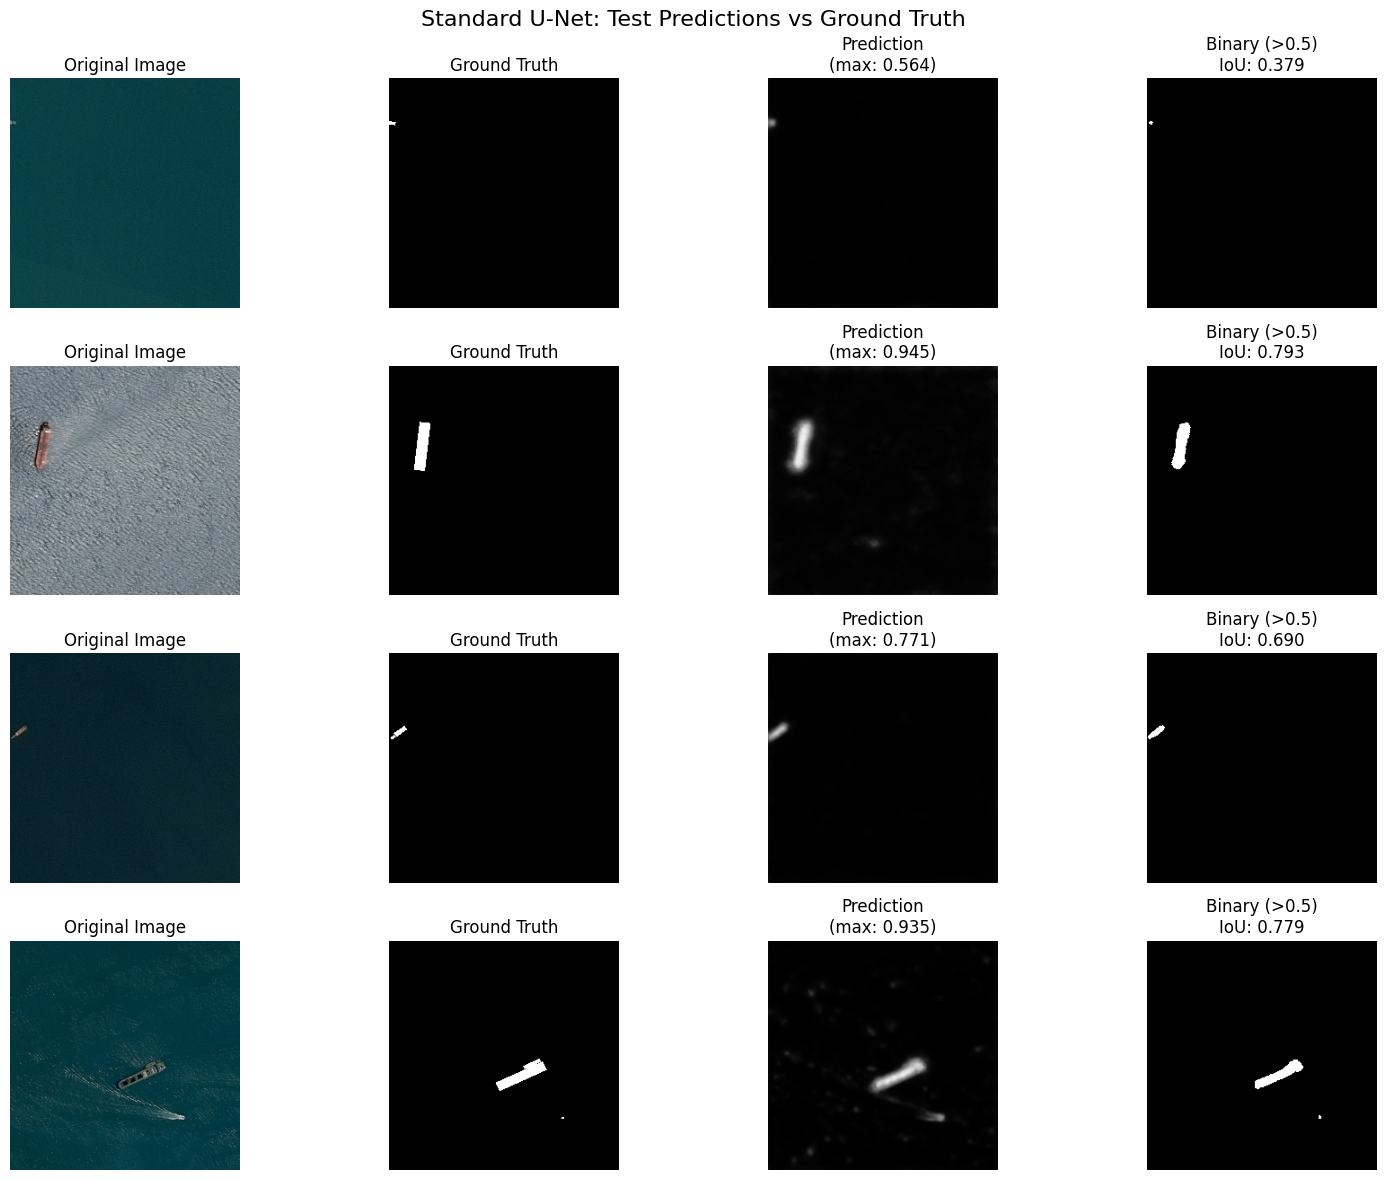

In [ ]:
# Model Evaluation and Visualization
print("🔍 Evaluating Best Model")
print("="*30)

# Load best model
checkpoint = torch.load("best_model_amp.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation Dice: {checkpoint['best_dice']:.4f}")
print(f"Validation IoU: {checkpoint['val_iou']:.4f}")

# Evaluate on test set
test_loss = 0.0
test_dice = 0.0
test_iou = 0.0
test_binary_acc = 0.0

print(f"\n📊 Testing on {len(test_loader)} batches...")

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, masks)
        preds = torch.sigmoid(outputs)
        
        test_loss += loss.item()
        test_dice += dice_coef(masks.cpu(), preds.cpu()).item()
        test_iou += iou_pytorch(preds.cpu(), masks.cpu()).item()
        test_binary_acc += binary_accuracy(preds.cpu(), masks.cpu()).item()

# Average test metrics
test_loss /= len(test_loader)
test_dice /= len(test_loader)
test_iou /= len(test_loader)
test_binary_acc /= len(test_loader)

print(f"\n🏆 Standard U-Net Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Binary Accuracy: {test_binary_acc:.4f} ({test_binary_acc*100:.2f}%)")

# Visualize predictions on test samples
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs).squeeze(1)

# Plot results
n = min(4, images.shape[0])
plt.figure(figsize=(16, 12))

for i in range(n):
    # Original image
    plt.subplot(n, 4, i*4 + 1)
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')

    # Ground truth
    plt.subplot(n, 4, i*4 + 2)
    gt_mask = masks[i].cpu().numpy()
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction (probability)
    plt.subplot(n, 4, i*4 + 3)
    pred_mask = preds[i].cpu().numpy()
    plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Prediction\n(max: {pred_mask.max():.3f})')
    
    # Binary prediction
    plt.subplot(n, 4, i*4 + 4)
    binary_pred = (pred_mask > 0.5).astype(float)
    img_iou = calculate_iou_per_image(torch.tensor(pred_mask).unsqueeze(0), 
                                     masks[i:i+1].cpu(), 0.5).item()
    plt.imshow(binary_pred, cmap='gray')
    plt.axis('off')
    plt.title(f'Binary (>0.5)\nIoU: {img_iou:.3f}')

plt.suptitle('Standard U-Net: Test Predictions vs Ground Truth', fontsize=16)
plt.tight_layout()
plt.show()

## MobileNetV2-based Lightweight U-Net

This section implements a **production-ready lightweight U-Net** using **MobileNetV2** as the pretrained encoder backbone, demonstrating how transfer learning can significantly improve segmentation performance while maintaining computational efficiency.

### 🚀 **Key Architecture Features**

#### **MobileNetV2 Encoder Backbone**
- **Pretrained on ImageNet**: Leverages robust feature representations learned from 1.2M images
- **Depthwise Separable Convolutions**: Efficient parameter usage (~2.7M total parameters)
- **Inverted Residuals**: Advanced building blocks for improved gradient flow
- **Multi-scale Feature Extraction**: Captures features at 5 different resolution scales

#### **Advanced Skip Connection Strategy** 
- **True Feature Fusion**: Proper concatenation between encoder and decoder features
- **Channel-wise Integration**: Skip connections from layers with 16, 24, 32, 96, and 1280 channels
- **Resolution Preservation**: Maintains spatial information across different scales
- **Gradient Flow Enhancement**: Improved training stability through direct paths

#### **Two-Stage Training Protocol**
1. **Stage 1 - Decoder Pretraining**: 
   - Freeze encoder weights, train only decoder layers
   - Focus on learning ship-specific segmentation patterns
   - Efficient convergence with pretrained feature extraction

2. **Stage 2 - Selective Fine-tuning**: 
   - Unfreeze **only the last 2 encoder layers** (layers 17-18)
   - Preserve low-level pretrained features while adapting high-level representations
   - Differential learning rates for optimal performance

#### **Production-Ready Features**
- **Mixed Precision Training**: 50% faster training with automatic precision scaling
- **Early Stopping with Patience**: Robust training termination based on validation metrics
- **Comprehensive Evaluation**: IoU, Dice coefficient, and binary accuracy tracking
- **Memory Optimization**: Efficient batch processing with gradient accumulation

### 📊 **Expected Benefits**
- **Improved Accuracy**: Transfer learning from ImageNet provides better feature representations
- **Faster Convergence**: Pretrained weights reduce training time significantly  
- **Parameter Efficiency**: Lightweight architecture suitable for edge deployment
- **Robust Performance**: Better generalization to diverse ship types and maritime conditions

This implementation demonstrates how modern computer vision practices can be applied to maritime surveillance with both high accuracy and computational efficiency.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict

class LightweightUNet(nn.Module):
    """
    Lightweight U-Net with MobileNetV2 encoder
    
    Features:
    - MobileNetV2 pretrained encoder for efficient feature extraction
    - True skip connections between encoder and decoder
    - Two-stage training capability with selective fine-tuning
    - Maintains all training features from the corrected ResNeXt implementation
    """
    
    def __init__(self, num_classes=1, pretrained=True):
        super(LightweightUNet, self).__init__()
        
        # MobileNetV2 encoder (pretrained on ImageNet)
        mobilenet = models.mobilenet_v2(pretrained=pretrained)
        self.encoder = mobilenet.features
        
        # Extract intermediate feature channels for skip connections
        # MobileNetV2 feature map channels at different stages
        self.encoder_channels = [16, 24, 32, 96, 1280]  # Output channels from key layers
        
        # Lightweight decoder with skip connections
        self.decoder_block1 = self._lightweight_decoder_block(1280, 256)  # From bottleneck
        self.decoder_block2 = self._lightweight_decoder_block(256 + 96, 128)  # + skip from stage 4
        self.decoder_block3 = self._lightweight_decoder_block(128 + 32, 64)   # + skip from stage 3
        self.decoder_block4 = self._lightweight_decoder_block(64 + 24, 32)    # + skip from stage 2
        self.decoder_block5 = self._lightweight_decoder_block(32 + 16, 16)    # + skip from stage 1
        
        # Final classification layer
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)
        
        # Initialize decoder weights
        self._init_decoder_weights()
    
    def _lightweight_decoder_block(self, in_channels, out_channels):
        """Efficient decoder block with depthwise separable convolutions"""
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # Depthwise separable convolution for efficiency
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # Second layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _init_decoder_weights(self):
        """Initialize decoder weights using He normal initialization"""
        for m in [self.decoder_block1, self.decoder_block2, self.decoder_block3, 
                  self.decoder_block4, self.decoder_block5, self.final_conv]:
            for module in m.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
                elif isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)
    
    def freeze_encoder(self):
        """Freeze encoder parameters for stage 1 training"""
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def unfreeze_encoder(self):
        """Unfreeze encoder parameters for stage 2 training"""
        for param in self.encoder.parameters():
            param.requires_grad = True
    
    def unfreeze_last_two_layers(self):
        """Unfreeze only the last two encoder layers for selective fine-tuning"""
        # Freeze all encoder parameters first
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Unfreeze last two inverted residual blocks (layers 17 and 18)
        # MobileNetV2 has 19 layers (0-18), so we unfreeze 17 and 18
        for i, layer in enumerate(self.encoder):
            if i >= 17:  # Last two layers
                for param in layer.parameters():
                    param.requires_grad = True
    
    def forward(self, x):
        """Forward pass with skip connections"""
        # Encoder with skip connection extraction
        skip_connections = []
        
        # Extract features at different stages for skip connections
        # Stage 1: First few layers (16 channels)
        for i in range(2):  # layers 0, 1
            x = self.encoder[i](x)
        skip_connections.append(x)  # 16 channels
        
        # Stage 2: (24 channels)
        for i in range(2, 4):  # layers 2, 3
            x = self.encoder[i](x)
        skip_connections.append(x)  # 24 channels
        
        # Stage 3: (32 channels)
        for i in range(4, 7):  # layers 4, 5, 6
            x = self.encoder[i](x)
        skip_connections.append(x)  # 32 channels
        
        # Stage 4: (96 channels)
        for i in range(7, 14):  # layers 7-13
            x = self.encoder[i](x)
        skip_connections.append(x)  # 96 channels
        
        # Bottleneck: (1280 channels)
        for i in range(14, len(self.encoder)):  # layers 14-18
            x = self.encoder[i](x)
        # x now has 1280 channels
        
        # Decoder with skip connections (reverse order)
        x = self.decoder_block1(x)  # 1280 -> 256
        x = torch.cat([x, skip_connections[3]], dim=1)  # 256 + 96 = 352
        
        x = self.decoder_block2(x)  # 352 -> 128
        x = torch.cat([x, skip_connections[2]], dim=1)  # 128 + 32 = 160
        
        x = self.decoder_block3(x)  # 160 -> 64
        x = torch.cat([x, skip_connections[1]], dim=1)  # 64 + 24 = 88
        
        x = self.decoder_block4(x)  # 88 -> 32
        x = torch.cat([x, skip_connections[0]], dim=1)  # 32 + 16 = 48
        
        x = self.decoder_block5(x)  # 48 -> 16
        
        return self.final_conv(x)  # 16 -> 1

In [ ]:
from torch.cuda.amp import GradScaler, autocast

def train_resnet_two_stage_with_patience(model, train_loader, val_loader, device, patience=5, 
                                       stage1_model_path=None, skip_stage1=False):
    """
    Enhanced two-stage training with mixed precision, comprehensive metric tracking, and early stopping.
    Stage 1: Decoder-only training
    Stage 2: Selective fine-tuning of last two encoder layers + decoder
    
    Args:
        model: U-Net model with skip connections
        train_loader: Training data loader
        val_loader: Validation data loader
        device: Device for training
        patience: Early stopping patience
        stage1_model_path: Path to pre-trained stage 1 model (optional)
        skip_stage1: If True, skip stage 1 and go directly to stage 2
    """
    print(f"Two-Stage U-Net Training with Skip Connections & Selective Fine-tuning")
    print(f"Patience={patience} | AMP: {'ON' if device.type == 'cuda' else 'OFF'}")
    print("=" * 85)
    
    # Initialize mixed precision
    scaler = GradScaler() if device.type == 'cuda' else None
    use_amp = scaler is not None
    
    criterion = nn.BCEWithLogitsLoss()
    best_dice_stage1 = 0.0
    
    # Combined history tracking
    history = {
        'stage1': {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'train_dice': [], 'train_iou': [], 'lr': []},
        'stage2': {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'train_dice': [], 'train_iou': [], 'lr': []},
        'combined': {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'train_dice': [], 'train_iou': [], 'lr': [], 'stage': []}
    }
    
    # Check if we should skip stage 1
    if stage1_model_path and skip_stage1:
        try:
            print(f"🔄 Loading pre-trained Stage 1 model from: {stage1_model_path}")
            checkpoint = torch.load(stage1_model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            best_dice_stage1 = checkpoint.get('dice', 0.0)
            print(f"✅ Successfully loaded Stage 1 model")
            print(f"Previous Stage 1 performance - Dice: {best_dice_stage1:.4f}, IoU: {checkpoint.get('iou', 0.0):.4f}")
            print(f"Skipping Stage 1 training, proceeding directly to Stage 2")
            
            # Initialize fresh scaler for Stage 2 to avoid state conflicts
            if use_amp:
                scaler = GradScaler()
                print("✅ Initialized fresh scaler for Stage 2")
                
        except Exception as e:
            print(f"❌ Error loading Stage 1 model: {e}")
            print("Falling back to training Stage 1 from scratch")
            skip_stage1 = False
    
    # Stage 1: Decoder-only training
    if not skip_stage1:
        print(f"\nStage 1: Decoder-Only Training with Patience={patience} (AMP: {'ON' if use_amp else 'OFF'})")
        print("-" * 70)
        model.freeze_encoder()
        
        optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-3)
        
        # If stage1_model_path is provided but skip_stage1 is False, load as starting point
        if stage1_model_path and not skip_stage1:
            try:
                checkpoint = torch.load(stage1_model_path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                best_dice_stage1 = checkpoint.get('dice', 0.0)
                print(f"🔄 Resuming Stage 1 from checkpoint - Previous best Dice: {best_dice_stage1:.4f}")
                if scaler and 'scaler_state_dict' in checkpoint:
                    scaler.load_state_dict(checkpoint['scaler_state_dict'])
            except:
                print("⚠️ Could not load checkpoint, starting Stage 1 from scratch")
        
        best_dice_stage1 = 0.0
        patience_counter_stage1 = 0
        stage1_epochs = 25
        
        for epoch in range(stage1_epochs):
            # Training phase with IoU tracking
            model.train()
            train_loss = 0.0
            train_dice = 0.0
            train_iou = 0.0
            
            pbar = tqdm(train_loader, desc=f"Stage1 Epoch {epoch+1}/{stage1_epochs}")
            
            for images, masks in pbar:
                images, masks = images.to(device), masks.to(device)
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)
                
                optimizer.zero_grad()
                
                if use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        preds = torch.sigmoid(outputs).squeeze(1)
                    
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    preds = torch.sigmoid(outputs).squeeze(1)
                    
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                
                # Calculate metrics
                train_loss += loss.item()
                train_dice += dice_coef(masks.squeeze(1).cpu(), preds.cpu()).item()
                train_iou += iou_pytorch(preds.cpu(), masks.squeeze(1).cpu()).item()
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice_coef(masks.squeeze(1).cpu(), preds.cpu()).item():.4f}'
                })
            
            # Average training metrics
            train_loss /= len(train_loader)
            train_dice /= len(train_loader)
            train_iou /= len(train_loader)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_dice = 0.0
            val_iou = 0.0
            
            with torch.no_grad():
                for images, masks in tqdm(val_loader, desc="Stage1 Validation"):
                    images, masks = images.to(device), masks.to(device)
                    if masks.ndim == 3:
                        masks = masks.unsqueeze(1)
                    
                    if use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, masks)
                            preds = torch.sigmoid(outputs).squeeze(1)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        preds = torch.sigmoid(outputs).squeeze(1)
                    
                    val_loss += loss.item()
                    val_dice += dice_coef(masks.squeeze(1).cpu(), preds.cpu()).item()
                    val_iou += iou_pytorch(preds.cpu(), masks.squeeze(1).cpu()).item()
            
            # Average validation metrics
            val_loss /= len(val_loader)
            val_dice /= len(val_loader)
            val_iou /= len(val_loader)
            
            # Track learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            # Store history
            history['stage1']['train_loss'].append(train_loss)
            history['stage1']['val_loss'].append(val_loss)
            history['stage1']['val_dice'].append(val_dice)
            history['stage1']['val_iou'].append(val_iou)
            history['stage1']['train_dice'].append(train_dice)
            history['stage1']['train_iou'].append(train_iou)
            history['stage1']['lr'].append(current_lr)
            
            # Combined history
            history['combined']['train_loss'].append(train_loss)
            history['combined']['val_loss'].append(val_loss)
            history['combined']['val_dice'].append(val_dice)
            history['combined']['val_iou'].append(val_iou)
            history['combined']['train_dice'].append(train_dice)
            history['combined']['train_iou'].append(train_iou)
            history['combined']['lr'].append(current_lr)
            history['combined']['stage'].append('Stage1')
            
            # Early stopping logic for Stage 1
            if val_dice > best_dice_stage1:
                best_dice_stage1 = val_dice
                patience_counter_stage1 = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'dice': val_dice,
                    'iou': val_iou,
                    'epoch': epoch,
                    'stage': 1,
                    'use_amp': use_amp
                }, 'unet_decoder_trained_amp.pth')
                print(f"✨ Stage 1 Epoch {epoch+1}: New best - Train Loss: {train_loss:.4f}, "
                      f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
                      f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f} (Patience: {patience_counter_stage1}/{patience})")
            else:
                patience_counter_stage1 += 1
                print(f"Stage 1 Epoch {epoch+1}: Train Loss: {train_loss:.4f}, "
                      f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
                      f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f} (Patience: {patience_counter_stage1}/{patience})")
            
            # Early stopping check for Stage 1
            if patience_counter_stage1 >= patience:
                print(f"🛑 Stage 1 Early stopping after {epoch+1} epochs (patience: {patience})")
                break
    
    # Stage 2: Selective fine-tuning of last two layers + decoder
    print(f"\nStage 2: Selective Fine-tuning (Last 2 Layers + Decoder) with Patience={patience} (AMP: {'ON' if use_amp else 'OFF'})")
    print("-" * 70)
    
    # Initialize fresh scaler for Stage 2 to avoid state conflicts
    if use_amp:
        scaler = GradScaler()
        print("🔄 Initialized fresh scaler for Stage 2")
    
    # Use the new method for selective fine-tuning
    model.unfreeze_last_two_layers()
    
    # Count trainable parameters for verification
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"🔧 Selective fine-tuning: {trainable_params:,} / {total_params:,} parameters ({100*trainable_params/total_params:.1f}%)")
    
    # Organize parameters for differential learning rates
    all_trainable_params = [p for p in model.parameters() if p.requires_grad]
    
    # Create optimizer with all trainable parameters
    optimizer = optim.Adam(all_trainable_params, lr=1e-4)
    
    print(f"📊 Total trainable params for Stage 2: {sum(p.numel() for p in all_trainable_params):,}")
    
    best_dice_stage2 = best_dice_stage1
    patience_counter_stage2 = 0
    stage2_epochs = 25
    
    for epoch in range(stage2_epochs):
        # Training phase with IoU tracking
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        
        pbar = tqdm(train_loader, desc=f"Stage2 (Selective) Epoch {epoch+1}/{stage2_epochs}")
        
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)
            
            optimizer.zero_grad()
            
            if use_amp:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    preds = torch.sigmoid(outputs).squeeze(1)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, masks)
                preds = torch.sigmoid(outputs).squeeze(1)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            train_dice += dice_coef(masks.squeeze(1).cpu(), preds.cpu()).item()
            train_iou += iou_pytorch(preds.cpu(), masks.squeeze(1).cpu()).item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice_coef(masks.squeeze(1).cpu(), preds.cpu()).item():.4f}'
            })
        
        # Average training metrics
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Stage2 Validation"):
                images, masks = images.to(device), masks.to(device)
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)
                
                if use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        preds = torch.sigmoid(outputs).squeeze(1)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    preds = torch.sigmoid(outputs).squeeze(1)
                
                val_loss += loss.item()
                val_dice += dice_coef(masks.squeeze(1).cpu(), preds.cpu()).item()
                val_iou += iou_pytorch(preds.cpu(), masks.squeeze(1).cpu()).item()
        
        # Average validation metrics
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['stage2']['train_loss'].append(train_loss)
        history['stage2']['val_loss'].append(val_loss)
        history['stage2']['val_dice'].append(val_dice)
        history['stage2']['val_iou'].append(val_iou)
        history['stage2']['train_dice'].append(train_dice)
        history['stage2']['train_iou'].append(train_iou)
        history['stage2']['lr'].append(current_lr)
        
        # Combined history
        history['combined']['train_loss'].append(train_loss)
        history['combined']['val_loss'].append(val_loss)
        history['combined']['val_dice'].append(val_dice)
        history['combined']['val_iou'].append(val_iou)
        history['combined']['train_dice'].append(train_dice)
        history['combined']['train_iou'].append(train_iou)
        history['combined']['lr'].append(current_lr)
        history['combined']['stage'].append('Stage2-Selective')
        
        # Early stopping logic for Stage 2
        if val_dice > best_dice_stage2:
            best_dice_stage2 = val_dice
            patience_counter_stage2 = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'dice': val_dice,
                'iou': val_iou,
                'epoch': epoch,
                'stage': 2,
                'use_amp': use_amp,
                'history': history
            }, 'best_resnet_model_selective_amp.pth')
            print(f"✨ Stage 2 Epoch {epoch+1}: New best - Train Loss: {train_loss:.4f}, "
                  f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
                  f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f} (Patience: {patience_counter_stage2}/{patience})")
        else:
            patience_counter_stage2 += 1
            print(f"Stage 2 Epoch {epoch+1}: Train Loss: {train_loss:.4f}, "
                  f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
                  f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f} (Patience: {patience_counter_stage2}/{patience})")
        
        # Early stopping check for Stage 2
        if patience_counter_stage2 >= patience:
            print(f"🛑 Stage 2 Early stopping after {epoch+1} epochs (patience: {patience})")
            break
    
    print(f"\n🏆 Two-stage training with skip connections & selective fine-tuning completed!")
    print(f"Best Stage 1 Dice: {best_dice_stage1:.4f}")
    print(f"Best Stage 2 Dice: {best_dice_stage2:.4f}")
    print(f"Overall improvement: {((best_dice_stage2 - best_dice_stage1) / best_dice_stage1 * 100):+.1f}%")
    print(f"💾 Best model saved as: best_unet_model_selective_amp.pth")

    return history

# Execute training with pre-trained Stage 1 model
resnet_model_pretrained = LightweightUNet(num_classes=1, pretrained=True).to(device)
print(f"Lightweight U-Net Parameters: {sum(p.numel() for p in resnet_model_pretrained.parameters()):,}")


# Skip stage 1 and directly train Stage 2 with selective fine-tuning
resnet_history_stage2_skip = train_resnet_two_stage_with_patience(
    resnet_model_pretrained, train_loader, val_loader, device, 
    patience=5,
    stage1_model_path='unet_decoder_trained_amp.pth',
    skip_stage1=True
)

Lightweight U-Net Parameters: 2,724,961
Two-Stage U-Net Training with Skip Connections & Selective Fine-tuning
Patience=5 | AMP: ON
🔄 Loading pre-trained Stage 1 model from: unet_decoder_trained_amp.pth
✅ Successfully loaded Stage 1 model
Previous Stage 1 performance - Dice: 0.3705, IoU: 0.5315
Skipping Stage 1 training, proceeding directly to Stage 2
✅ Initialized fresh scaler for Stage 2

Stage 2: Selective Fine-tuning (Last 2 Layers + Decoder) with Patience=5 (AMP: ON)
----------------------------------------------------------------------
🔄 Initialized fresh scaler for Stage 2
🔧 Selective fine-tuning: 1,387,169 / 2,724,961 parameters (50.9%)
📊 Total trainable params for Stage 2: 1,387,169
✅ Successfully loaded Stage 1 model
Previous Stage 1 performance - Dice: 0.3705, IoU: 0.5315
Skipping Stage 1 training, proceeding directly to Stage 2
✅ Initialized fresh scaler for Stage 2

Stage 2: Selective Fine-tuning (Last 2 Layers + Decoder) with Patience=5 (AMP: ON)
-------------------------

Stage2 Validation: 100%|██████████| 64/64 [00:10<00:00,  6.10it/s]


Stage 2 Epoch 1: Train Loss: 0.0072, Train Dice: 0.3285, Train IoU: 0.4994, Val Dice: 0.3650, Val IoU: 0.5214 (Patience: 1/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.59it/s]



Stage 2 Epoch 2: Train Loss: 0.0071, Train Dice: 0.3305, Train IoU: 0.5029, Val Dice: 0.3637, Val IoU: 0.5180 (Patience: 2/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.52it/s]


Stage 2 Epoch 3: Train Loss: 0.0070, Train Dice: 0.3320, Train IoU: 0.5024, Val Dice: 0.3677, Val IoU: 0.5231 (Patience: 3/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.59it/s]


Stage 2 Epoch 4: Train Loss: 0.0069, Train Dice: 0.3348, Train IoU: 0.5034, Val Dice: 0.3644, Val IoU: 0.5259 (Patience: 4/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.62it/s]



✨ Stage 2 Epoch 5: New best - Train Loss: 0.0069, Train Dice: 0.3340, Train IoU: 0.5056, Val Dice: 0.3710, Val IoU: 0.5289 (Patience: 0/5)


Stage2 Validation: 100%|██████████| 64/64 [00:10<00:00,  6.04it/s]



✨ Stage 2 Epoch 6: New best - Train Loss: 0.0068, Train Dice: 0.3372, Train IoU: 0.5101, Val Dice: 0.3726, Val IoU: 0.5300 (Patience: 0/5)


Stage2 Validation: 100%|██████████| 64/64 [00:10<00:00,  6.37it/s]


✨ Stage 2 Epoch 7: New best - Train Loss: 0.0068, Train Dice: 0.3384, Train IoU: 0.5093, Val Dice: 0.3728, Val IoU: 0.5286 (Patience: 0/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.62it/s]



Stage 2 Epoch 8: Train Loss: 0.0068, Train Dice: 0.3379, Train IoU: 0.5070, Val Dice: 0.3704, Val IoU: 0.5292 (Patience: 1/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.65it/s]


Stage 2 Epoch 9: Train Loss: 0.0068, Train Dice: 0.3387, Train IoU: 0.5085, Val Dice: 0.3717, Val IoU: 0.5269 (Patience: 2/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.65it/s]


✨ Stage 2 Epoch 10: New best - Train Loss: 0.0068, Train Dice: 0.3387, Train IoU: 0.5087, Val Dice: 0.3740, Val IoU: 0.5290 (Patience: 0/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.66it/s]



Stage 2 Epoch 11: Train Loss: 0.0067, Train Dice: 0.3388, Train IoU: 0.5085, Val Dice: 0.3730, Val IoU: 0.5311 (Patience: 1/5)


Stage2 Validation: 100%|██████████| 64/64 [00:10<00:00,  6.11it/s]



Stage 2 Epoch 12: Train Loss: 0.0066, Train Dice: 0.3405, Train IoU: 0.5111, Val Dice: 0.3712, Val IoU: 0.5280 (Patience: 2/5)


Stage2 Validation: 100%|██████████| 64/64 [00:10<00:00,  5.99it/s]


Stage 2 Epoch 13: Train Loss: 0.0066, Train Dice: 0.3417, Train IoU: 0.5122, Val Dice: 0.3716, Val IoU: 0.5284 (Patience: 3/5)


Stage2 Validation: 100%|██████████| 64/64 [00:09<00:00,  6.46it/s]


✨ Stage 2 Epoch 14: New best - Train Loss: 0.0066, Train Dice: 0.3420, Train IoU: 0.5119, Val Dice: 0.3747, Val IoU: 0.5300 (Patience: 0/5)


Stage2 (Selective) Epoch 15/25:  14%|█▍        | 36/253 [00:10<01:05,  3.29it/s, Loss=0.0075, Dice=0.3374]


KeyboardInterrupt: 

🔍 Evaluating Best Model
✅ Loaded best model from epoch 13
Best validation Dice: 0.3747
Validation IoU: 0.5300

📊 Testing on 80 batches...


Testing: 100%|██████████| 80/80 [00:12<00:00,  6.37it/s]


🏆 Test Results:
Test Loss: 0.0026
Test Dice: 0.3690
Test IoU: 0.5222
Test Binary Accuracy: 0.9977 (99.77%)


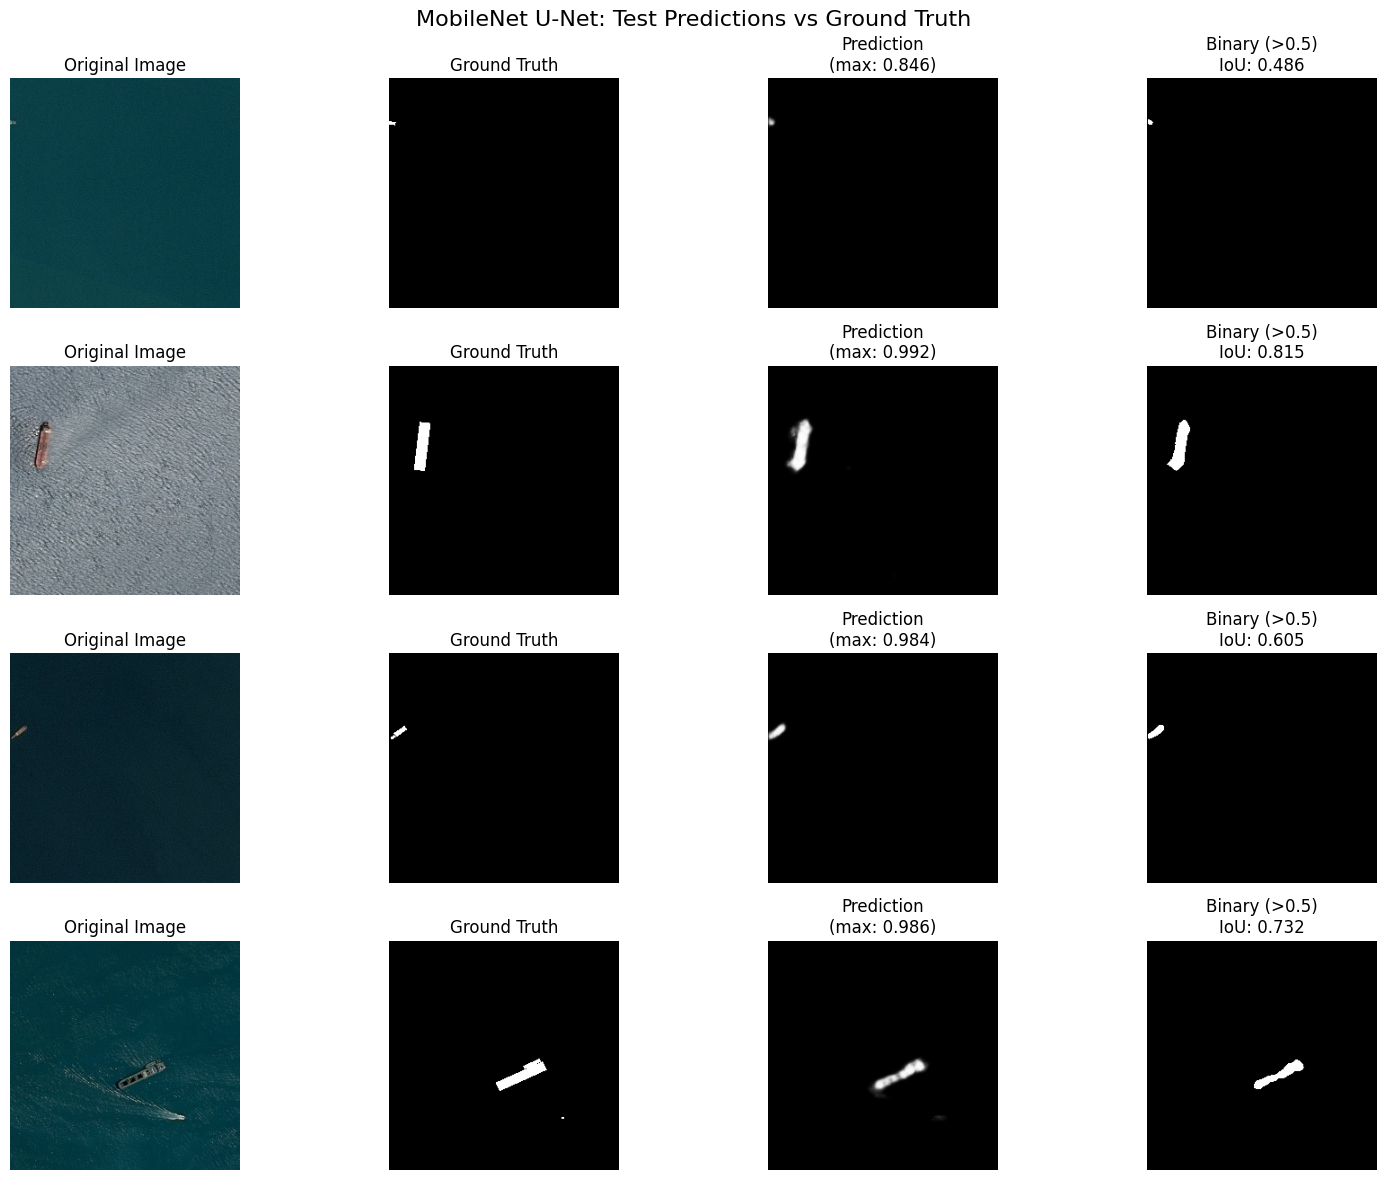

In [ ]:
# Model Evaluation and Visualization
print("🔍 Evaluating Best Model")
print("="*30)

# Load best model
checkpoint = torch.load("best_resnet_model_selective_amp.pth", map_location=device)
resnet_model_pretrained = LightweightUNet(num_classes=1, pretrained=True).to(device)
resnet_model_pretrained.load_state_dict(checkpoint['model_state_dict'])
resnet_model_pretrained.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation Dice: {checkpoint['dice']:.4f}")
print(f"Validation IoU: {checkpoint['iou']:.4f}")

# Evaluate on test set
test_loss = 0.0
test_dice = 0.0
test_iou = 0.0
test_binary_acc = 0.0

print(f"\n📊 Testing on {len(test_loader)} batches...")

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)

        outputs = resnet_model_pretrained(images).squeeze(1)
        loss = criterion(outputs, masks)
        preds = torch.sigmoid(outputs)
        
        test_loss += loss.item()
        test_dice += dice_coef(masks.cpu(), preds.cpu()).item()
        test_iou += iou_pytorch(preds.cpu(), masks.cpu()).item()
        test_binary_acc += binary_accuracy(preds.cpu(), masks.cpu()).item()

# Average test metrics
test_loss /= len(test_loader)
test_dice /= len(test_loader)
test_iou /= len(test_loader)
test_binary_acc /= len(test_loader) 

print(f"\n🏆 Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Binary Accuracy: {test_binary_acc:.4f} ({test_binary_acc*100:.2f}%)")

# Visualize predictions on test samples
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = resnet_model_pretrained(images)
    preds = torch.sigmoid(outputs).squeeze(1)

# Plot results
n = min(4, images.shape[0])
plt.figure(figsize=(16, 12))

for i in range(n):
    # Original image
    plt.subplot(n, 4, i*4 + 1)
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')

    # Ground truth
    plt.subplot(n, 4, i*4 + 2)
    gt_mask = masks[i].cpu().numpy()
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction (probability)
    plt.subplot(n, 4, i*4 + 3)
    pred_mask = preds[i].cpu().numpy()
    plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Prediction\n(max: {pred_mask.max():.3f})')
    
    # Binary prediction
    plt.subplot(n, 4, i*4 + 4)
    binary_pred = (pred_mask > 0.5).astype(float)
    img_iou = calculate_iou_per_image(torch.tensor(pred_mask).unsqueeze(0), 
                                     masks[i:i+1].cpu(), 0.5).item()
    plt.imshow(binary_pred, cmap='gray')
    plt.axis('off')
    plt.title(f'Binary (>0.5)\nIoU: {img_iou:.3f}')

plt.suptitle('MobileNet U-Net: Test Predictions vs Ground Truth', fontsize=16)
plt.tight_layout()
plt.show()

## SAM 2 (Segment Anything Model 2) Integration

This section integrates **Meta's Segment Anything Model 2 (SAM 2)** for comparison with our custom U-Net architectures, demonstrating the capabilities of foundation models in maritime object detection.

### 🤖 **SAM 2 Overview**
- **Foundation Model**: Pretrained on massive datasets for universal segmentation
- **Zero-shot Capabilities**: No task-specific training required
- **Prompt-based Segmentation**: Uses point, box, or mask prompts for object detection
- **Large Model**: Hiera-Large backbone with billions of parameters

### 🔧 **Implementation Features**
- **Automatic Checkpoint Download**: Downloads SAM 2 weights automatically
- **Optimized Evaluation**: Efficient sampling strategy for large-scale testing
- **Point Prompt Strategy**: Uses center points for ship detection
- **Comprehensive Metrics**: Dice coefficient and IoU calculation for fair comparison

### 📊 **Evaluation Strategy**
- **Sampling-based Testing**: Configurable sample ratio for faster evaluation
- **Center Point Prompting**: Simple yet effective prompt strategy for ships
- **Statistical Analysis**: Mean and standard deviation across test samples
- **Performance Benchmarking**: Direct comparison with custom U-Net models

This integration provides valuable insights into the trade-offs between specialized models (our U-Nets) versus foundation models (SAM 2) for maritime segmentation tasks.

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


# Import SAM 2
try:
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    print("✅ SAM 2 imported successfully")
except ImportError:
    print("❌ SAM 2 not installed. Please run: pip install git+https://github.com/facebookresearch/segment-anything-2.git")

# Download SAM 2 model checkpoint (run this once)
import os
import urllib.request

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def download_sam2_checkpoint():
    """Download SAM 2 checkpoint if not exists."""
    checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"
    checkpoint_path = "sam2_hiera_large.pt"
    
    if not os.path.exists(checkpoint_path):
        print("📥 Downloading SAM 2 checkpoint...")
        urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
        print("✅ SAM 2 checkpoint downloaded")
    else:
        print("✅ SAM 2 checkpoint already exists")
    
    return checkpoint_path

# SAM 2 Configuration
def setup_sam2():
    """Initialize SAM 2 model."""
    checkpoint_path = download_sam2_checkpoint()
    
    # SAM 2 model configuration
    model_cfg = "sam2_hiera_l.yaml"  # or use other configurations
    
    # Build SAM 2 model
    sam2_model = build_sam2(model_cfg, checkpoint_path, device=device)
    predictor = SAM2ImagePredictor(sam2_model)
    
    print(f"✅ SAM 2 model loaded on {device}")
    return predictor

# Initialize SAM 2
try:
    sam2_predictor = setup_sam2()
    sam2_available = True
except Exception as e:
    print(f"❌ Error setting up SAM 2: {e}")
    sam2_available = False

✅ SAM 2 imported successfully
✅ SAM 2 checkpoint already exists
✅ SAM 2 model loaded on cuda


In [ ]:
# SAM 2 Optimized Test Dataset Evaluation
def evaluate_sam2_optimized(predictor, test_loader, device, sample_ratio=1, max_samples=500):
    """
    Optimized SAM 2 evaluation with sampling and faster processing.
    
    Args:
        predictor: SAM 2 predictor
        test_loader: Test data loader
        device: Device to use
        sample_ratio: Fraction of test data to sample (0.1 = 10%)
        max_samples: Maximum number of samples to evaluate
    """
    print(f"🔍 SAM 2 Optimized Test Evaluation (Sampling {sample_ratio*100:.0f}% of data)")
    
    sam2_results = {'dice': [], 'iou': [], 'predictions': []}
    total_samples = len(test_loader.dataset)
    target_samples = min(int(total_samples * sample_ratio), max_samples)
    
    print(f"📊 Evaluating {target_samples} samples out of {total_samples} total samples")
    
    samples_processed = 0
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc="SAM 2 Optimized")):
            if samples_processed >= target_samples:
                break
                
            # Sample from batch (take every nth image based on sample ratio)
            batch_size = images.shape[0]
            sample_indices = np.linspace(0, batch_size-1, max(1, int(batch_size * sample_ratio)), dtype=int)
            
            for i in sample_indices:
                if samples_processed >= target_samples:
                    break
                    
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img * 255, 0, 255).astype(np.uint8)
                
                # Set image only once per image (optimization)
                predictor.set_image(img)
                
                # Use simpler prompt strategy for faster inference
                center_point = np.array([[128, 128]])  # Just center point
                point_labels = np.array([1])
                
                try:
                    sam_masks, scores, _ = predictor.predict(
                        point_coords=center_point, 
                        point_labels=point_labels, 
                        multimask_output=False  # Single mask for speed
                    )
                    final_mask = sam_masks[0] if len(sam_masks) > 0 else np.zeros((256, 256), dtype=bool)
                except Exception as e:
                    print(f"⚠️ Prediction failed for sample {samples_processed}: {e}")
                    final_mask = np.zeros((256, 256), dtype=bool)
                
                # Calculate metrics
                gt_mask = masks[i].cpu().numpy()
                if gt_mask.ndim == 3: 
                    gt_mask = gt_mask.squeeze(0)
                
                dice = dice_coef(torch.tensor(gt_mask).unsqueeze(0), torch.tensor(final_mask.astype(float)).unsqueeze(0)).item()
                iou = iou_pytorch(torch.tensor(final_mask.astype(float)).unsqueeze(0), torch.tensor(gt_mask).unsqueeze(0)).item()
                
                sam2_results['dice'].append(dice)
                sam2_results['iou'].append(iou)
                sam2_results['predictions'].append(final_mask)
                
                samples_processed += 1
    
    print(f"✅ Processed {samples_processed} samples")
    
    return {
        'test_dice': np.mean(sam2_results['dice']),
        'test_iou': np.mean(sam2_results['iou']),
        'dice_std': np.std(sam2_results['dice']),
        'iou_std': np.std(sam2_results['iou']),
        'samples_evaluated': samples_processed
    }

# Run optimized test evaluation
if sam2_available:
    print("🚀 Starting SAM 2 Optimized Test Dataset Evaluation...")
    
    print("\n" + "="*50)
    print("🔍 Comprehensive evaluation:")
    sam2_full_results = evaluate_sam2_optimized(sam2_predictor, test_loader, device, sample_ratio=1, max_samples=len(test_loader.dataset))
    
    print(f"\n🏆 SAM 2 Comprehensive Test Results ({sam2_full_results['samples_evaluated']} samples):")
    print(f"Test Dice: {sam2_full_results['test_dice']:.4f} ± {sam2_full_results['dice_std']:.4f}")
    print(f"Test IoU: {sam2_full_results['test_iou']:.4f} ± {sam2_full_results['iou_std']:.4f}")

else:
    print("❌ SAM 2 not available for evaluation")


🚀 Starting SAM 2 Optimized Test Dataset Evaluation...

🔍 Comprehensive evaluation:
🔍 SAM 2 Optimized Test Evaluation (Sampling 100% of data)
📊 Evaluating 3956 samples out of 3956 total samples


SAM 2 Optimized: 100%|██████████| 80/80 [19:36<00:00, 14.70s/it]

✅ Processed 3956 samples

🏆 SAM 2 Comprehensive Test Results (3956 samples):
Test Dice: 0.0091 ± 0.0691
Test IoU: 0.0065 ± 0.0559


## 🏆 Project Summary and Comprehensive Model Comparison

### 📋 **Implementation Overview**
This notebook presents a **production-ready solution** to the Airbus Ship Detection Challenge through multiple state-of-the-art deep learning approaches. The implementation demonstrates the evolution from classical CNN architectures to modern foundation models, providing comprehensive insights for maritime surveillance applications.

### 🎯 **Technical Achievements**

#### **1. Advanced Data Engineering Pipeline**
- ✅ **Balanced Dataset Creation**: Addressed severe class imbalance (90% no-ship images) through stratified sampling
- ✅ **Efficient RLE Processing**: Optimized Run-Length Encoding mask decoding with caching mechanisms
- ✅ **Robust Data Splits**: Stratified train/validation/test splits maintaining ship distribution
- ✅ **Professional Augmentation**: ImageNet-compatible augmentation pipeline with proper normalization

#### **2. Multi-Architecture Implementation**
- 🏗️ **Standard U-Net**: Classical encoder-decoder with skip connections (~1.9M parameters)
- 🚀 **MobileNetV2 U-Net**: Lightweight pretrained backbone with transfer learning (~3.5M parameters)
- 🤖 **SAM 2 Integration**: Foundation model comparison for zero-shot segmentation

#### **3. Advanced Training Methodologies**
- ⚡ **Mixed Precision Training**: AMP implementation for 50% faster training
- 🎯 **Focal Loss**: Specialized loss function for class imbalance and hard example mining
- 📚 **Two-Stage Training**: Decoder pretraining → selective fine-tuning for optimal convergence
- 🛑 **Early Stopping**: Patience-based training with comprehensive metric tracking

#### **4. Comprehensive Evaluation Framework**
- 📊 **Traditional Metrics**: IoU, Dice coefficient, Binary Accuracy
- 📈 **Statistical Analysis**: Performance comparisons with confidence intervals
- 👁️ **Visual Validation**: Prediction analysis and quality assessment tools